sum_CsCh mean value: 1.1538449265937167 SD value: 0.1556631338959985
sum_Cs_5DIZ mean value: 1.3355667168655059 SD value: 0.34749442726341134
sum_LDA_5DIZ mean value: 1.2332266119499422 SD value: 0.2547683035304905
sum_OCT_5DIZ mean value: 1.5086353242662534 SD value: 0.5667940503051174
sum_LDA_OCT_5DIZ mean value: 1.7449944993644966 SD value: 1.0002030192189548
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ   0.1817 0.0001  0.0676  0.2959   True
        CsCh     LDA_5DIZ   0.0794  0.271 -0.0295  0.1883  False
        CsCh LDA_OCT_5DIZ   0.5911    0.0  0.4543   0.728   True
        CsCh     OCT_5DIZ   0.3548    0.0  0.2391  0.4705   True
     Cs_5DIZ     LDA_5DIZ  -0.1023 0.0973 -0.2154  0.0107  False
     Cs_5DIZ LDA_OCT_5DIZ   0.4094    0.0  0.2693  0.5496   True
     Cs_5DIZ     OCT_5DIZ   0.1731 0.0008  0.0535 

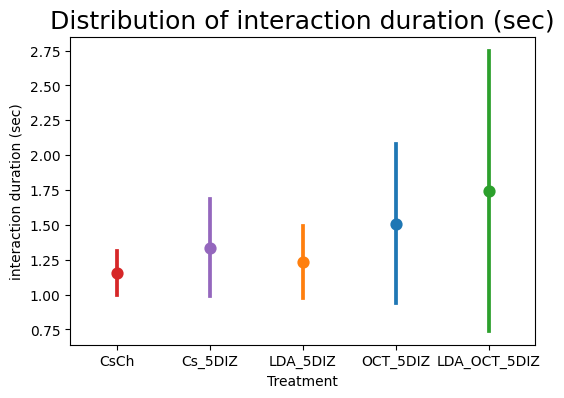

sum_CsCh mean value: 24.084420289855075 SD value: 4.511604605150091
sum_Cs_5DIZ mean value: 21.21916666666667 SD value: 3.535729435192813
sum_LDA_5DIZ mean value: 23.006597222222222 SD value: 5.158450276433488
sum_OCT_5DIZ mean value: 23.718859649122805 SD value: 4.527105937934752
sum_LDA_OCT_5DIZ mean value: 24.03787878787879 SD value: 6.87784960561285
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ  -2.8653    0.0 -4.0334 -1.6971   True
        CsCh     LDA_5DIZ  -1.0778 0.0638 -2.1927   0.037  False
        CsCh LDA_OCT_5DIZ  -0.0465    1.0 -1.4471  1.3541  False
        CsCh     OCT_5DIZ  -0.3656  0.917   -1.55  0.8189  False
     Cs_5DIZ     LDA_5DIZ   1.7874 0.0003  0.6307  2.9442   True
     Cs_5DIZ LDA_OCT_5DIZ   2.8187    0.0  1.3845  4.2529   True
     Cs_5DIZ     OCT_5DIZ   2.4997    0.0  1.2757  3.7237  

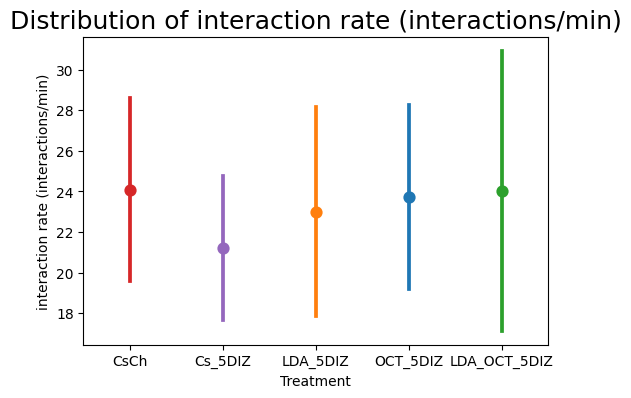

sum_CsCh mean value: 0.009464207290294223 SD value: 0.019278959980765793
sum_Cs_5DIZ mean value: 0.014119318181818158 SD value: 0.0426549873024915
sum_LDA_5DIZ mean value: 0.01205281986531984 SD value: 0.035046057967260506
sum_OCT_5DIZ mean value: 0.015782828282828256 SD value: 0.047198024273764634
sum_LDA_OCT_5DIZ mean value: 0.03287419651056012 SD value: 0.10939878810740807
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ   0.0047 0.8367 -0.0076  0.0169  False
        CsCh     LDA_5DIZ   0.0026 0.9742 -0.0091  0.0143  False
        CsCh LDA_OCT_5DIZ   0.0234 0.0001  0.0087  0.0381   True
        CsCh     OCT_5DIZ   0.0063 0.6328 -0.0061  0.0187  False
     Cs_5DIZ     LDA_5DIZ  -0.0021 0.9903 -0.0142    0.01  False
     Cs_5DIZ LDA_OCT_5DIZ   0.0188  0.006  0.0037  0.0338   True
     Cs_5DIZ     OCT_5DIZ   0.0017 0

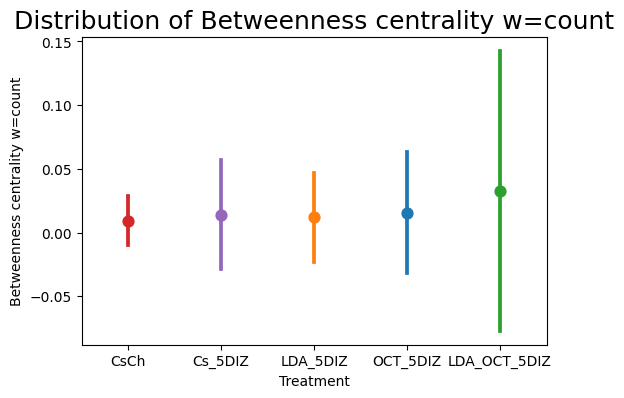

sum_CsCh mean value: 0.016090250329380728 SD value: 0.02975697266208097
sum_Cs_5DIZ mean value: 0.022253787878787845 SD value: 0.041886879336889046
sum_LDA_5DIZ mean value: 0.019049873737373706 SD value: 0.04145131722802236
sum_OCT_5DIZ mean value: 0.02416267942583729 SD value: 0.046685158840048674
sum_LDA_OCT_5DIZ mean value: 0.04359504132231402 SD value: 0.10889409838745107
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ   0.0062  0.676 -0.0066  0.0189  False
        CsCh     LDA_5DIZ    0.003 0.9635 -0.0092  0.0151  False
        CsCh LDA_OCT_5DIZ   0.0275    0.0  0.0123  0.0428   True
        CsCh     OCT_5DIZ   0.0081 0.4277 -0.0048   0.021  False
     Cs_5DIZ     LDA_5DIZ  -0.0032 0.9576 -0.0158  0.0094  False
     Cs_5DIZ LDA_OCT_5DIZ   0.0213 0.0018  0.0057   0.037   True
     Cs_5DIZ     OCT_5DIZ   0.0019  

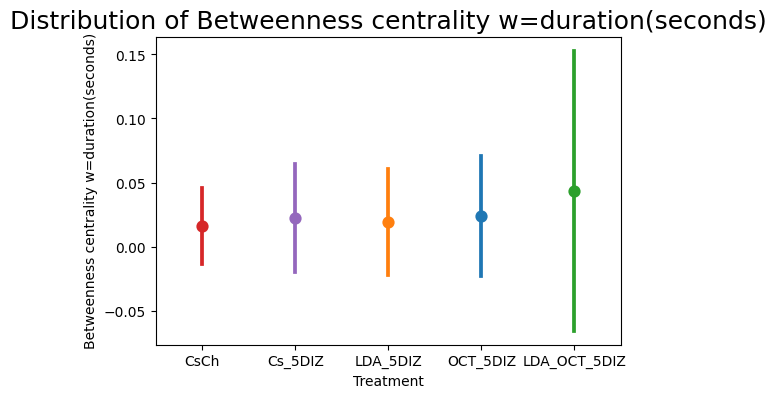

sum_CsCh mean value: 481.68840579710144 SD value: 90.23209210300182
sum_Cs_5DIZ mean value: 424.3833333333333 SD value: 70.71458870385626
sum_LDA_5DIZ mean value: 460.13194444444446 SD value: 103.16900552866976
sum_OCT_5DIZ mean value: 474.37719298245617 SD value: 90.54211875869504
sum_LDA_OCT_5DIZ mean value: 480.75757575757575 SD value: 137.556992112257
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
        CsCh      Cs_5DIZ -57.3051    0.0 -80.6676 -33.9425   True
        CsCh     LDA_5DIZ -21.5565 0.0638 -43.8534   0.7404  False
        CsCh LDA_OCT_5DIZ  -0.9308    1.0 -28.9428  27.0812  False
        CsCh     OCT_5DIZ  -7.3112  0.917 -31.0003  16.3779  False
     Cs_5DIZ     LDA_5DIZ  35.7486 0.0003  12.6135  58.8837   True
     Cs_5DIZ LDA_OCT_5DIZ  56.3742    0.0  27.6906  85.0579   True
     Cs_5DIZ     OCT_5DIZ  49.9939    0

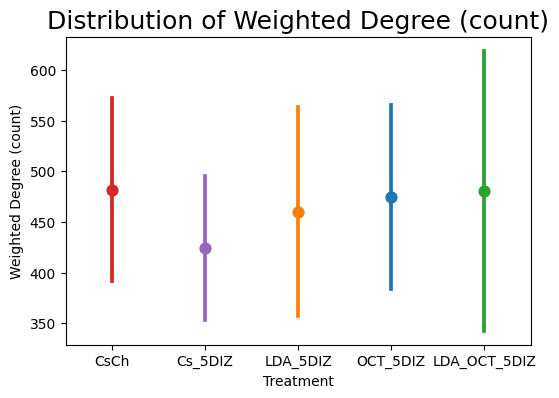

sum_CsCh mean value: 556.8762077294685 SD value: 133.13119617345896
sum_Cs_5DIZ mean value: 569.2222222222222 SD value: 191.90514811960387
sum_LDA_5DIZ mean value: 565.6909722222222 SD value: 170.46091184127826
sum_OCT_5DIZ mean value: 739.9480994152048 SD value: 406.9785769057481
sum_LDA_OCT_5DIZ mean value: 777.9349747474748 SD value: 305.03723089683075
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj    lower    upper   reject
-------------------------------------------------------------------
        CsCh      Cs_5DIZ   12.346 0.9806  -47.8156  72.5076  False
        CsCh     LDA_5DIZ   8.8148 0.9935  -48.6026  66.2321  False
        CsCh LDA_OCT_5DIZ 221.0588    0.0  148.9243 293.1933   True
        CsCh     OCT_5DIZ 183.0719    0.0  122.0694 244.0744   True
     Cs_5DIZ     LDA_5DIZ  -3.5313 0.9998   -63.107  56.0445  False
     Cs_5DIZ LDA_OCT_5DIZ 208.7128    0.0  134.8487 282.5768   True
     Cs_5DIZ     OCT_5DIZ 170.

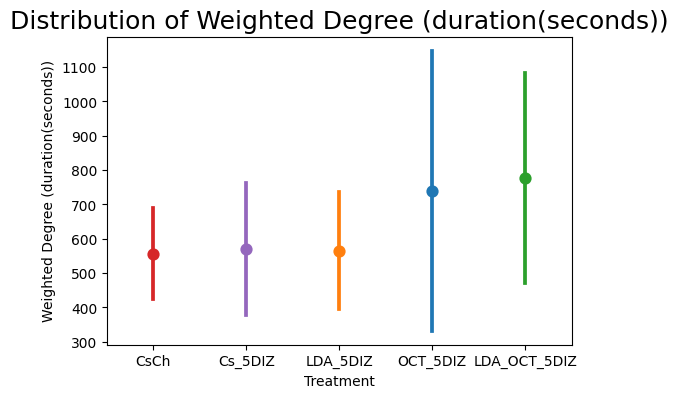

sum_CsCh mean value: 0.5557638704452255 SD value: 0.06387866417426748
sum_Cs_5DIZ mean value: 0.5211000342187012 SD value: 0.06534846804453895
sum_LDA_5DIZ mean value: 0.5162641030767694 SD value: 0.07538992461681467
sum_OCT_5DIZ mean value: 0.511364251327807 SD value: 0.06461139476611343
sum_LDA_OCT_5DIZ mean value: 0.46733272268119497 SD value: 0.09059773476968945
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ  -0.0347    0.0 -0.0518 -0.0176   True
        CsCh     LDA_5DIZ  -0.0395    0.0 -0.0558 -0.0232   True
        CsCh LDA_OCT_5DIZ  -0.0884    0.0 -0.1089 -0.0679   True
        CsCh     OCT_5DIZ  -0.0444    0.0 -0.0617 -0.0271   True
     Cs_5DIZ     LDA_5DIZ  -0.0048 0.9362 -0.0218  0.0121  False
     Cs_5DIZ LDA_OCT_5DIZ  -0.0538    0.0 -0.0748 -0.0328   True
     Cs_5DIZ     OCT_5DIZ  -0.0097 0.5724 -0.0

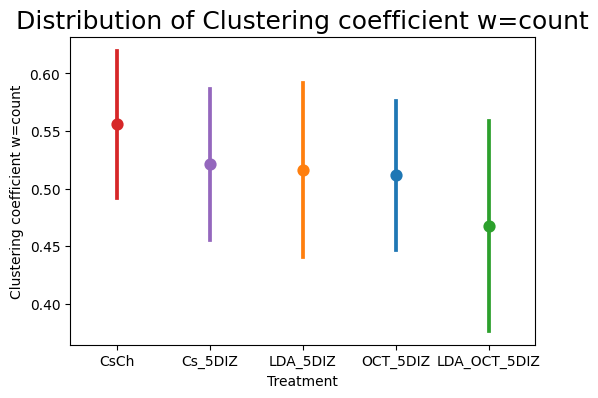

sum_CsCh mean value: 0.4634823793770364 SD value: 0.08737925268287766
sum_Cs_5DIZ mean value: 0.43543937535388866 SD value: 0.08336429132443983
sum_LDA_5DIZ mean value: 0.41675143645983925 SD value: 0.09339944069466327
sum_OCT_5DIZ mean value: 0.37902360181940675 SD value: 0.09976473188905273
sum_LDA_OCT_5DIZ mean value: 0.3408042900903299 SD value: 0.12012882524484994
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
        CsCh      Cs_5DIZ   -0.028 0.0076  -0.051 -0.0051   True
        CsCh     LDA_5DIZ  -0.0467    0.0 -0.0686 -0.0249   True
        CsCh LDA_OCT_5DIZ  -0.1227    0.0 -0.1501 -0.0952   True
        CsCh     OCT_5DIZ  -0.0845    0.0 -0.1077 -0.0612   True
     Cs_5DIZ     LDA_5DIZ  -0.0187 0.1621 -0.0414   0.004  False
     Cs_5DIZ LDA_OCT_5DIZ  -0.0946    0.0 -0.1228 -0.0665   True
     Cs_5DIZ     OCT_5DIZ  -0.0564    0.0 -

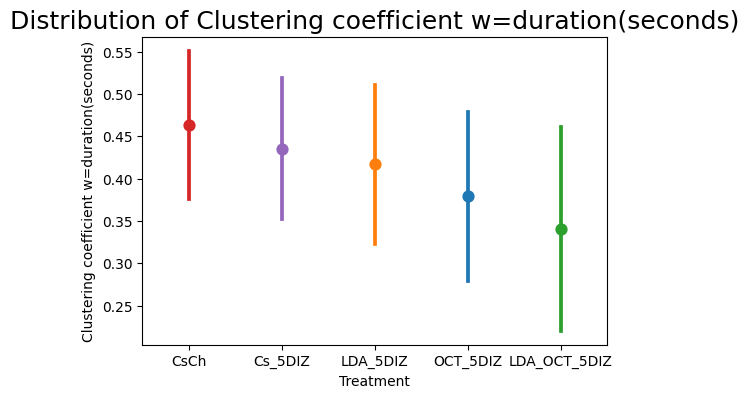

In [3]:
import os
import toml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

from src import settings
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)  
INPUT_PATH = os.path.join(settings.RESULTS_DIR, "local_measures")
all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

treatment_dataframes = pd.DataFrame()
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)

    for group_name, group_path in all_groups.items():
        df = pd.read_csv(group_path, index_col=0)
        df.rename_axis("Fly")
        df['Treatment'] = treatment_name
        df['Group'] = group_name.replace(".csv", "")
        treatment_dataframes = pd.concat([treatment_dataframes, df])

treatment_dataframes = treatment_dataframes.set_index('Treatment', append=True)
treatment_dataframes = treatment_dataframes.set_index('Group',append=True)
combined_data_reset = treatment_dataframes.reset_index()

combined_data_reset["interaction duration (sec)"] = combined_data_reset["Weighted Degree (duration(seconds))"]/combined_data_reset['Weighted Degree (count)']
combined_data_reset["interaction rate (interactions/min)"] = combined_data_reset['Weighted Degree (count)'] / (config['EXPERIMENT_DURATION']/60)

measures = [
    'interaction duration (sec)',
    'interaction rate (interactions/min)',

    'Betweenness centrality w=count',
    'Betweenness centrality w=duration(seconds)',
    
    'Weighted Degree (count)',
    'Weighted Degree (duration(seconds))',
    'Clustering coefficient w=count',
    'Clustering coefficient w=duration(seconds)',
]

for measure_name in measures:
    treatment_sums = {}
    for treatment in config['TREATMENTS']:
        treatment_sums[f'sum_{treatment}'] = combined_data_reset[combined_data_reset['Treatment'] == treatment][measure_name]

    anova_result = scipy.stats.f_oneway(*treatment_sums.values())

    all_data = np.concatenate([*treatment_sums.values()])
    group_labels = []
    for treatment in config['TREATMENTS']:
        group_labels.extend([treatment] * len(combined_data_reset[combined_data_reset['Treatment'] == treatment][measure_name]))

    tukey_results = pairwise_tukeyhsd(all_data, group_labels)

    # if any(tukey_results.reject):
    for treatment in treatment_sums.keys():
        print(f"{treatment} mean value: {np.mean(treatment_sums[treatment])} SD value: {np.std(treatment_sums[treatment])}")
    print(tukey_results)

    plt.figure(figsize=(6, 4))
    sns.pointplot(data=combined_data_reset, x='Treatment', y=measure_name, hue='Treatment', errorbar='sd', order=config['TREATMENTS'])
    # sns.boxplot(data=combined_data_reset, x='Treatment', y=measure_name, hue='Treatment', order=order)
    
    plt.xlabel('Treatment')
    plt.ylabel(measure_name)
    plt.title(f'Distribution of {measure_name}', fontsize=18)
    plt.legend().remove()
    plt.show() 


In [3]:
combined_data_reset.columns

Index(['level_0', 'Treatment', 'Group', 'Weighted degree w=count',
       'Weighted degree w=duration', 'Degree centrality',
       'In-degree centrality', 'Out-degree centrality',
       'Eigenvector centrality', 'Closeness centrality',
       'In-Strength distribution, w=count',
       'Out-Strength distribution, w=count',
       'In-Strength distribution, w=duration',
       'Out-Strength distribution, w=duration', 'Weighted Degree (count)',
       'Weighted Degree (duration(seconds))', 'In-degree', 'Out-degree',
       'Selectivity', 'Betweenness centrality w=None',
       'Betweenness centrality w=count',
       'Betweenness centrality w=duration(seconds)',
       'Clustering coefficient w=None', 'Clustering coefficient w=count',
       'Clustering coefficient w=duration(seconds)', 'PageRank centrality',
       'interaction duration (sec)', 'interaction rate (interactions/min)'],
      dtype='object')